In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


auspol2019.csv
location_geocode.csv



In [9]:
import numpy as np
import pandas as pd
import os
import string
import re
import warnings 
warnings.filterwarnings('ignore')

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline


#PLOTLY
import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from collections import defaultdict
from plotly import tools
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)
from textblob import TextBlob
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import squarify

Our goal is to see if twitter sentiment can be a good predictor for the outcome of an election. We have access to 18k tweets collected from the twitter API in relation to the 2019 Australian election in addition to geographic data that can be merged to the twitter data. The data can be found here :
https://www.kaggle.com/taniaj/australian-election-2019-tweets


In [2]:
#Read in the Data 
twitter_data = pd.read_csv('../input/auspol2019.csv',parse_dates=['created_at','user_created_at'])
geo_data = pd.read_csv('../input/location_geocode.csv')

Lets check the first few rows of our geo data in addition to the election related tweets

In [3]:
twitter_data.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar,nparmar1957,"Life coach & trainer, Motivational speaker, Ma...","Wollongong, NSW, AUSTRALIA",2012-08-23 10:20:40
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells,peterwells,Writes for @theage and @smh on technology and ...,Melbourne,2006-12-11 07:38:06
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist,therealist822,"Calls it as I see it. Anti PC, SJW and VS. If ...",NaN,2017-09-14 03:10:30
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business,InquirerBiz,The official Twitter account of the Inquirer G...,Philippines,2012-03-16 03:51:59


In [4]:
geo_data.head()

,name,lat,long
0,"Brisbane, Queensland",-27.469771,153.025124
1,"Wollongong, NSW, AUSTRALIA",-34.427812,150.893061
2,Melbourne,-37.813628,144.963058
3,Philippines,12.879721,121.774017
4,Australia,-25.274398,133.775136


Check the Dimensions of each data set 

In [5]:
twitter_data.shape

(183379, 11)

In [6]:
geo_data.shape

(11153, 3)

Combine the geo data and the twitter data. We are able to do this by performing a join on userlocation and name. We will re-check our new data frame to validate that the join performed what we wanted to. While we are at it, lets also get the day of the week names specifically for the day the user account was created and the day the tweet was fired off. We will also generate the hour of day that the tweet was created and the hour of day where the user account was extracted. 

In [15]:
#merging two data frames based on user location
twitter_data = twitter_data.merge(geo_data, how='inner', left_on='user_location', right_on='name')

twitter_data['tweeted_day_of_week'] = twitter_data['created_at'].dt.weekday_name

twitter_data['created_day_of_week'] = twitter_data['user_created_at'].dt.weekday_name

twitter_data['created_at_hour'] = twitter_data['created_at'].dt.hour

twitter_data['user_created_at_hour'] = twitter_data['user_created_at'].dt.hour

twitter_data.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,name_x,lat_x,long_x,name_y,lat_y,long_y,tweeted_day_of_week,created_day_of_week,name,lat,long,created_at_hour,user_created_at_hour
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45,"Brisbane, Queensland",-27.469771,153.025124,"Brisbane, Queensland",-27.469771,153.025124,Monday,Wednesday,"Brisbane, Queensland",-27.469771,153.025124,9,9
1,2019-05-20 09:12:57,1130401009782673408,It is disappointing that @tanya_plibersek has ...,0.0,0.0,5.100258e+07,Matthew Rimmer,DrRimmer,Professor of IP & Innovation Law @QUTLaw @QUT_...,"Brisbane, Queensland",2009-06-26 10:17:54,"Brisbane, Queensland",-27.469771,153.025124,"Brisbane, Queensland",-27.469771,153.025124,Monday,Friday,"Brisbane, Queensland",-27.469771,153.025124,9,10
2,2019-05-20 09:02:04,1130398270813949952,'Vote for the climate': NSW demands environmen...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45,"Brisbane, Queensland",-27.469771,153.025124,"Brisbane, Queensland",-27.469771,153.025124,Monday,Wednesday,"Brisbane, Queensland",-27.469771,153.025124,9,9
3,2019-05-20 07:25:41,1130374015103537152,This is urgent! “False election claims spark p...,0.0,0.0,3.327641e+08,E Ferri,eneferri,"Writer, researcher, educator in media, adverti...","Brisbane, Queensland",2011-07-10 11:20:43,"Brisbane, Queensland",-27.469771,153.025124,"Brisbane, Queensland",-27.469771,153.025124,Monday,Sunday,"Brisbane, Queensland",-27.469771,153.025124,7,11
4,2019-05-20 07:12:01,1130370578584461313,"This is a great piece, not least because it pl...",0.0,2.0,2.180023e+09,Shahar Hameiri,ShaharHameiri,Associate Professor @polsisengage @UQ_news. Po...,"Brisbane, Queensland",2013-11-07 12:39:24,"Brisbane, Queensland",-27.469771,153.025124,"Brisbane, Queensland",-27.469771,153.025124,Monday,Thursday,"Brisbane, Queensland",-27.469771,153.025124,7,12


Lets examine the number of tweets by Date

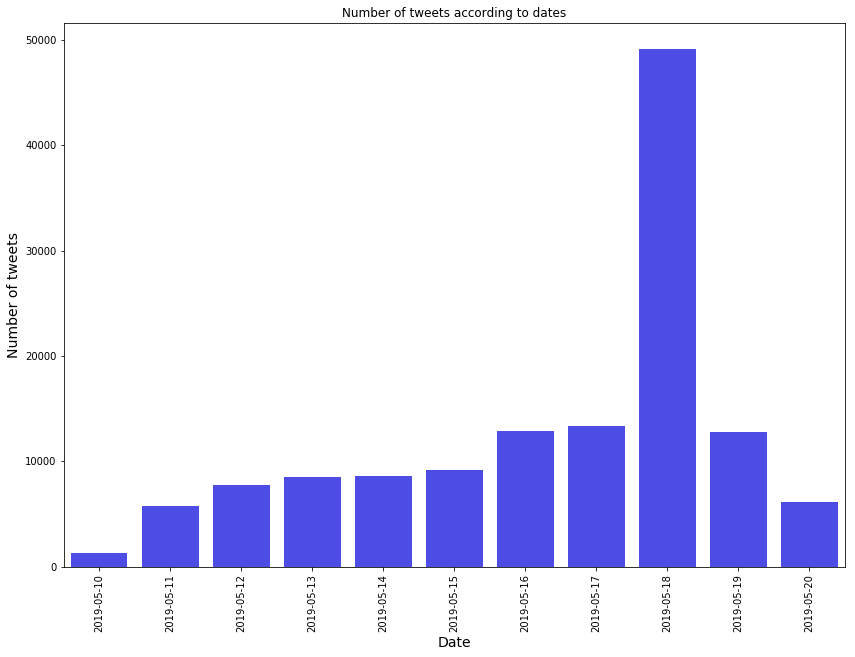

In [14]:
#lets explore created_at column
twitter_data['created_at'] =  pd.to_datetime(twitter_data['created_at'])

cnt_srs = twitter_data['created_at'].dt.date.value_counts()

cnt_srs = cnt_srs.sort_index()

plt.figure(figsize=(14,10))

sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='blue')

plt.xticks(rotation='vertical')

plt.xlabel('Date', fontsize=14)

plt.ylabel('Number of tweets', fontsize=14)

plt.title("Number of tweets according to dates")

plt.show()

We can see that the majority of tweets happened on the 18th of May with roughly a little under 50k. Lets now look at the number of tweets per hour of day. It would be interesting to see if more tw